## 导库

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

## 读取数据

In [35]:
df = pd.read_csv("credit-overdue.csv")
X = df[["debt","income"]].values
y = df["overdue"].values

## 数据预处理

In [36]:
# 标准化特征
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 添加偏置项
X_b = np.c_[np.ones((X_scaled.shape[0],1)), X_scaled]

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_b, y, test_size = 0.2, random_state = 42, stratify = y)

## 定义模型和训练函数

In [37]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_loss(y,y_pred):
    epsilon = 1e-8
    return -np.mean(y * np.log(y_pred + epsilon) + (1 - y) * np.log(1 - y_pred + epsilon))

def gradient_descent(X, y, theta, alpha, iterations):
    m = len(y)
    loss_history = []
    for _ in range(iterations):
        z = np.dot(X, theta)       # 线性组合
        h = sigmoid(z)             # 预测概率
        gradient = np.dot(X.T, (h - y)) / m  # 梯度计算
        theta -= alpha * gradient  # 参数更新
        loss = compute_loss(y, h)  # 记录损失
        loss_history.append(loss)
    return theta, loss_history

# 初始化参数
theta = np.zeros(X_train.shape[1])
alpha = 0.1
iterations = 1000

# 训练模型
theta, loss_history = gradient_descent(X_train, y_train, theta, alpha, iterations)

## 损失函数

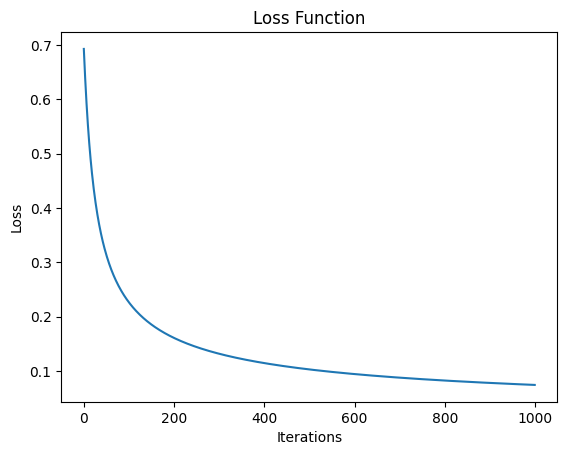

In [42]:
plt.plot(loss_history)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss Function")
plt.show()

## 分类线

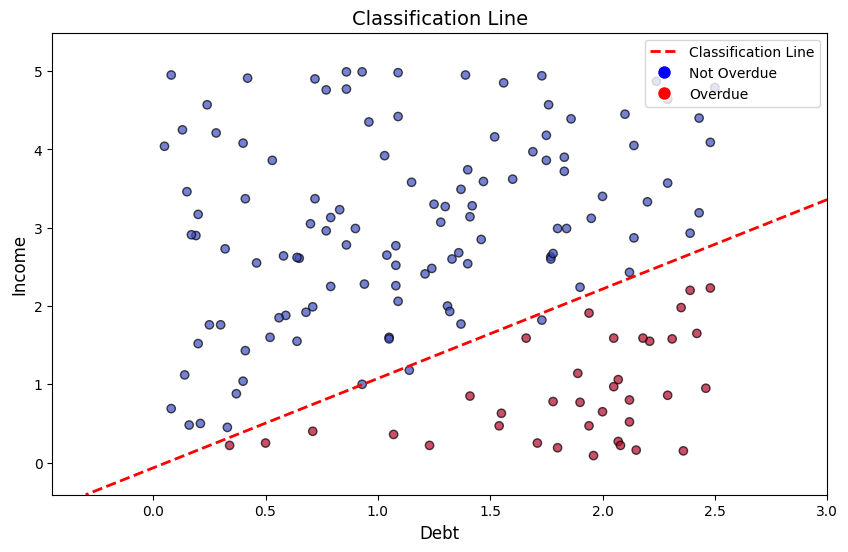

In [39]:
# 参数转换
mean_debt, mean_income = scaler.mean_
std_debt, std_income = scaler.scale_
theta0 = theta[0]
theta1 = theta[1]
theta2 = theta[2]

A = -theta1 / theta2 * (std_income / std_debt)
B = (-theta0 / theta2 * std_income) + mean_income - (theta1 / theta2) * (std_income / std_debt) * mean_debt

# 生成网格点
x1_min, x1_max = df["debt"].min() - 0.5, df["debt"].max() + 0.5
x2_min, x2_max = df["income"].min() - 0.5, df["income"].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x1_min, x1_max, 500), 
                     np.linspace(x2_min, x2_max, 500))

# 预测概率并绘制
grid = np.c_[xx.ravel(), yy.ravel()]
grid_scaled = scaler.transform(grid)
grid_b = np.c_[np.ones((len(grid_scaled), 1)), grid_scaled]
probs = sigmoid(grid_b @ theta).reshape(xx.shape)

# 绘制图形
plt.figure(figsize=(10, 6))

# 绘制散点图
plt.scatter(df["debt"], df["income"], c=df["overdue"], cmap=plt.cm.coolwarm, edgecolors="k", alpha=0.7)

# 绘制分类线
classification_line = plt.contour(xx, yy, probs, levels=[0.5], colors="red", linewidths=2, linestyles="dashed")

# 自定义图例条目
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], color="red", linestyle="--", linewidth=2, label="Classification Line"),
    Line2D([0], [0], marker="o", color="w", markerfacecolor="blue", markersize=10, label="Not Overdue"),
    Line2D([0], [0], marker="o", color="w", markerfacecolor="red", markersize=10, label="Overdue")
]

# 添加图例
plt.legend(handles=legend_elements, loc="upper right")

# 添加标签和标题
plt.xlabel("Debt", fontsize=12)
plt.ylabel("Income", fontsize=12)
plt.title("Classification Line", fontsize=14)

# 显示图形
plt.show()

## 交叉验证

In [40]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for train_index, test_index in kf.split(X_scaled):
    X_train_cv, X_test_cv = X_scaled[train_index], X_scaled[test_index]
    y_train_cv, y_test_cv = y[train_index], y[test_index]
    
    X_train_b_cv = np.c_[np.ones((X_train_cv.shape[0], 1)), X_train_cv]
    X_test_b_cv = np.c_[np.ones((X_test_cv.shape[0], 1)), X_test_cv]
    
    theta_cv = np.zeros(X_train_b_cv.shape[1])
    theta_cv, _ = gradient_descent(X_train_b_cv, y_train_cv, theta_cv, alpha=0.1, iterations=1000)
    
    y_pred_prob_cv = sigmoid(np.dot(X_test_b_cv, theta_cv))
    y_pred_cv = (y_pred_prob_cv >= 0.5).astype(int)
    
    accuracy = accuracy_score(y_test_cv, y_pred_cv)
    cv_scores.append(accuracy)

print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))
print("Standard Deviation:", np.std(cv_scores))

Cross-Validation Accuracy Scores: [1.0, 1.0, 1.0, 0.9666666666666667, 0.9666666666666667]
Mean Accuracy: 0.9866666666666667
Standard Deviation: 0.016329931618554516


## 分类报告

In [41]:
y_pred_prob = sigmoid(np.dot(X_test, theta))
y_pred = (y_pred_prob >= 0.5).astype(int)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        23
           1       0.88      1.00      0.93         7

    accuracy                           0.97        30
   macro avg       0.94      0.98      0.96        30
weighted avg       0.97      0.97      0.97        30

